In [17]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

This is NWAY Python API
nwaylib file /Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/nwaylib/__init__.py


In [18]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import cat2hpx, pandas_to_fits, my_scaler_forward
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import astropy.io.fits as fits
import healpy as hp
import nway_python_api as nway
%matplotlib inline

# LH X-ray catalog

Read catalog and create a fits table with positions and positional errors

`pos_r98` - radius of a circle which has a probability of finding a counterpart is 98% if it exists, in arcseconds

In [19]:
xcat_orig = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl')

positional_error_columns = 'pos_r68'
print('*'*50)
print('using positional error columns:', positional_error_columns)
print('*'*50)

columns_to_retain = ['srcname_fin', 'RA_fin', 'DEC_fin', positional_error_columns, 'ML_FLUX_0'] 


xcat = xcat_orig[xcat_orig['DET_LIKE_0']>6]
xcat = xcat[columns_to_retain]
xcat.rename(columns={'RA_fin':'RA', 'DEC_fin':'DEC', positional_error_columns:'pos_err', 'srcname_fin': 'ID'}, inplace=True)

def r98_correction(r98):
    if r98<5:
        return 5
    else:
        return r98*1.1

#xcat['pos_err'] = xcat['pos_err'].apply(r98_correction)

**************************************************
using positional error columns: pos_r68
**************************************************


In [20]:
xcat_orig.head(2)
#pos_sigma_2d fitted with gaia offsets

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH
0,SRGe J103744.3+571156,159.434594,57.198788,151.771105,51.782607,2.041112,26414.902344,3.284168e-12,3.904461e-13,15460.503906,1838.058594,4300.765625,0.0,0.0,0.0,1,1,159.436603,57.197499,0.318530,6.785297,0.000011,6.268413e+08,6.270701e+08,0.0,0.0,3.594826,0.427379,20.898417,159.434594,57.198788,853989860956388736,6.040749,1,0,15.749939,-1.0,0,87GB 103431.3+572750,0.8307,BLLac,6.040664,4,1,1,1,12.218,11.328,9.144,46.2,51.7,34.4,1,3,1,1237658303278743603,7980433077213351936,6.099201,65741514189,0.318530,0.729711,1.101567,1.786149,134.901685,44.066998,2.527295e-12,5.451755e+19
1,SRGe J110137.5+572926,165.406353,57.490464,147.861359,53.996717,2.144203,5344.646973,1.969860e-12,5.570020e-14,1436.945923,40.631405,666.426941,0.0,0.0,0.0,21,14,165.408362,57.489175,0.433455,41.040825,0.000030,6.268413e+08,6.270701e+08,0.0,0.0,2.156194,0.060969,4.025409,165.406353,57.490464,857143329024245888,7.121849,2,1,10.012074,NaN,0,HD 237963,NaN,Star,7.105646,1,1,0,0,8.146,8.155,8.124,47.2,55.3,51.5,1,3,1,1237658302206378052,0,3.844748,64609311305,0.433455,0.766567,1.157204,1.876362,138.528408,46.042071,1.515884e-12,7.056474e+19


In [21]:
xcat_orig[['pos_r98', 'pos_sigma_2d', 'pos_r68', 'pos_r95']].describe().loc[['mean', 'std', '25%', '50%', '75%']]

,pos_r98,pos_sigma_2d,pos_r68,pos_r95
mean,8.311198,2.971310,4.485466,7.273014
std,4.529825,1.619443,2.444699,3.963987
25%,5.779061,2.066054,3.118898,5.057176
50%,7.927672,2.834197,4.278481,6.937396
75%,9.985523,3.569892,5.389082,8.738193


## area and plotting

Resolution of the HEALPix map:
0.05725810686362343 deg per pixel, or
3.435486411817406 arcmin per pixel, or
206.12918470904435 arcsec per pixel
18.385776415407125 sq. deg.


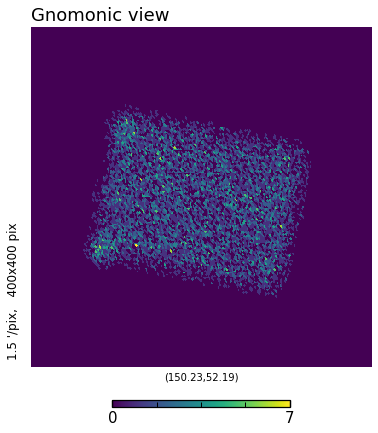

In [22]:
xcat_hp_map = cat2hpx(xcat['RA'], xcat['DEC'], nside=1024, radec=True)
hp.gnomview(xcat_hp_map, rot = [150.23,52.19], xsize = 400)

ERO_SKYAREA = 4*np.pi*(np.rad2deg(1))**2 * np.sum(xcat_hp_map>=1)/len(xcat_hp_map)
print(ERO_SKYAREA, 'sq. deg.')

In [23]:
pandas_to_fits(dataframe = xcat, 
                filename = 'ERO_lhpv_03_23_sd01_a15_g14.fits',
                table_header_name = 'eROSITA',
                sky_area_deg2 = ERO_SKYAREA)

In [26]:
xcat[['RA', 'DEC']].describe().loc[['min', 'max']]

,RA,DEC
min,154.763934,54.124219
max,167.084550,61.236185


## Random catalog

In [15]:
nway.create_shifted_catalogue(inputfile=data_path+'ERO_lhpv_03_23_sd01_a15_g14.fits', outputfile=data_path+'ERO_lhpv_03_23_sd01_a15_g14_shifted.fits', shift_dec=300, radius=40)

opening /Users/sdbykov/work/lockman_hole/0_data/ERO_lhpv_03_23_sd01_a15_g14.fits
    using RA  column: RA
    using DEC column: DEC


100%|██████████| 9500/9500 [00:06<00:00, 1480.85it/s]

removed 1325 sources which collide with original positions
writing "/Users/sdbykov/work/lockman_hole/0_data/ERO_lhpv_03_23_sd01_a15_g14_shifted.fits" (8175 rows)


# LH DESI catalog

All DESI objects within LH area + a little boundary


In [32]:
desi_cat_orig = pd.read_pickle(data_path+'desi_lh.gz_pkl', compression='gzip')
print(len(desi_cat_orig), 'original objects')


#from 1_csc-desi-photo-prior/0_train0catalogs.ipynb
#desi_cat = desi_cat_orig.query('brick_primary == True')
desi_cat = desi_cat_orig.copy()
desi_cat = desi_cat.sort_values(by=['flux_g'], ascending=[False])
#print(len(desi_cat), 'after brick_primary == True filter')
#step 2: remove duplicates in ['ra_csc', 'dec_csc', 'ra', 'dec'] and keep the one with the highest flux_g 
desi_cat = desi_cat.drop_duplicates(subset=['ra', 'dec'], keep='first')
print(len(desi_cat), 'after removing duplicates')



tm_desi_id=desi_cat['release'].astype(str)+'_'+desi_cat['brickid'].astype(str)+'_'+desi_cat['objid'].astype(str)
desi_cat['desi_id'] = tm_desi_id


columns_to_retain = ['desi_id', 'ra', 'dec', 'dered_mag_g', 'dered_mag_r', 'dered_mag_z', 'dered_mag_w1', 'dered_mag_w2'] 
desi_cat = desi_cat[columns_to_retain]


#TODO mag_g -> dered_mag_g
desi_cat.rename(columns={'dered_mag_g':'mag_g', 'dered_mag_r': 'mag_r', 'dered_mag_z': 'mag_z', 'dered_mag_w1': 'mag_w1', 'dered_mag_w2': 'mag_w2'}, inplace=True) 

desi_cat.reset_index(inplace=True, drop = True)
desi_cat

2418574 original objects
2418574 after removing duplicates


,desi_id,ra,dec,mag_g,mag_r,mag_z,mag_w1,mag_w2
0,9011_606802_2605,165.460954,56.382573,2.915254,2.087654,1.722280,5.013193,5.196579
1,9011_605177_2992,157.655218,55.980398,4.877345,4.564330,4.505185,6.241055,6.745312
2,9011_608375_2337,158.790917,57.082795,5.150754,5.013778,5.079414,6.963816,7.265361
3,9011_609165_2169,160.930717,57.198968,5.623667,5.891215,6.298098,8.569067,9.066921
4,9011_615262_2652,162.848613,59.319899,5.885894,5.040292,4.663559,5.754431,6.882899
...,...,...,...,...,...,...,...,...
2418569,9011_605995_1099,162.677475,56.208173,NaN,12.384571,12.580270,11.265625,11.922470
2418570,9011_606803_804,165.704475,56.477614,NaN,20.383986,19.796894,19.892883,20.136581
2418571,9011_602737_2527,162.350176,55.280935,NaN,11.567264,13.174446,10.263829,10.691053
2418572,9011_605989_2125,160.095394,56.140614,NaN,10.741294,11.897931,11.090126,11.727248


Add color columns to the catalog

In [33]:
desi_cat['col_gr'] = desi_cat['mag_g'] - desi_cat['mag_r']
desi_cat['col_rz'] = desi_cat['mag_r'] - desi_cat['mag_z']
desi_cat['col_zw1'] = desi_cat['mag_z'] - desi_cat['mag_w1']
desi_cat['col_rw2'] = desi_cat['mag_r'] - desi_cat['mag_w2']
desi_cat = desi_cat.replace([np.inf, -np.inf], np.nan)
print(desi_cat.columns)
print('check the order of columns, they should coincide with the order of columns used for training model')

Index(['desi_id', 'ra', 'dec', 'mag_g', 'mag_r', 'mag_z', 'mag_w1', 'mag_w2',
       'col_gr', 'col_rz', 'col_zw1', 'col_rw2'],
      dtype='object')
check the order of columns, they should coincide with the order of columns used for training model


In [34]:
desi_cat_scaled = my_scaler_forward(desi_cat)

In [35]:
desi_cat_scaled.isna().sum()

desi_id         0
ra              0
dec             0
mag_g       48927
mag_r       12784
mag_z       16129
mag_w1     296366
mag_w2     583125
col_gr      56467
col_rz      27894
col_zw1    303279
col_rw2    591874
dtype: int64

In [36]:
print(len(desi_cat_scaled))
print(len(desi_cat_scaled.dropna(how = 'any')))

2418574
1684838


load prior model, scale the dataframe and assign a column prior_probability

In [37]:
from joblib import load
nn = load('../1_csc-desi-photo-prior/model/nn.joblib')

In [38]:
features_cols = ['mag_g','mag_r','mag_z','mag_w1','mag_w2','col_gr','col_rz','col_zw1','col_rw2']

In [39]:
desi_cat_scaled_nadropped= desi_cat_scaled.dropna(subset = features_cols, how = 'any')
df_of_mean = pd.DataFrame(desi_cat_scaled_nadropped.describe().loc['mean']).T
df_of_mean


,ra,dec,mag_g,mag_r,mag_z,mag_w1,mag_w2,col_gr,col_rz,col_zw1,col_rw2
mean,160.95648,57.729127,0.668905,0.642801,0.617421,0.595146,0.60522,0.091365,0.088831,0.07796,0.131534


In [40]:
desi_cat_orig_scaled_imputed = desi_cat_scaled.copy()

for col in features_cols:
    mean_val = df_of_mean[col].values[0]
    desi_cat_orig_scaled_imputed[col] = desi_cat_orig_scaled_imputed[col].fillna(mean_val)
desi_cat_orig_scaled_imputed.isna().sum()


desi_id    0
ra         0
dec        0
mag_g      0
mag_r      0
mag_z      0
mag_w1     0
mag_w2     0
col_gr     0
col_rz     0
col_zw1    0
col_rw2    0
dtype: int64

In [41]:
tmp_predict_features = desi_cat_orig_scaled_imputed[features_cols]

predict_proba = nn.predict_proba(tmp_predict_features)[:, 1]

desi_cat['nnprior'] = predict_proba

/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


## area and plotting

In [48]:
desi_hp_map = cat2hpx(desi_cat['ra'], desi_cat['dec'], nside=1024, radec=True)

Resolution of the HEALPix map:
0.05725810686362343 deg per pixel, or
3.435486411817406 arcmin per pixel, or
206.12918470904435 arcsec per pixel


41.728630922842704 sq. deg.
DESI sky density: 301541.4529958129 per sq deg
DESI sky density: 83.76151472105914 per sq. arcmin
DESI sky density: 0.02326708742251643 per sq. arcsec
 number of DESI sources within 5 arcsec radius 1.8273927729252275
 number of DESI sources within 10 arcsec radius 7.30957109170091


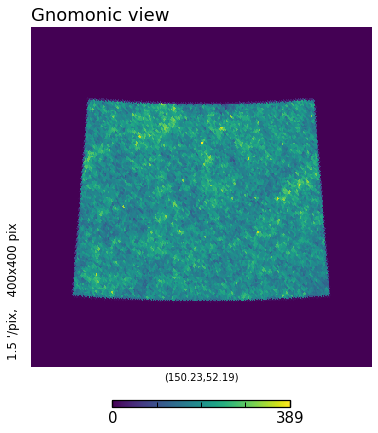

In [50]:
%matplotlib inline
hp.gnomview(desi_hp_map, rot = [150.23,52.19], xsize = 400)

DESI_SKYAREA = 4*np.pi*(np.rad2deg(1))**2 * np.sum(desi_hp_map>=1)/len(desi_hp_map)
print(DESI_SKYAREA, 'sq. deg.')

desi_sky_dens = len(desi_hp_map)/DESI_SKYAREA
print('DESI sky density:', desi_sky_dens, 'per sq deg')
print('DESI sky density:', desi_sky_dens/(3600), 'per sq. arcmin')
print('DESI sky density:', desi_sky_dens/(3600**2), 'per sq. arcsec')
print(' number of DESI sources within 5 arcsec radius', np.pi*5**2 * desi_sky_dens/(3600**2))
print(' number of DESI sources within 10 arcsec radius', np.pi*10**2 * desi_sky_dens/(3600**2))



In [57]:
pandas_to_fits(dataframe = desi_cat, 
                filename = 'desi_lh.fits',
                table_header_name = 'DESI',
                sky_area_deg2 = DESI_SKYAREA)